In [1]:
import torch
import timm
import sys
sys.path.append('..')
from models.fusion_model import FusionModel
from models.resnet_plus_model import ResNetPlusModel
from pytorch_lightning import LightningDataModule, LightningModule, Trainer
from data.wildlife_dataset import WildlifeDataModule
from wildlife_datasets import analysis, datasets, loader
from data.raptors_wildlife import Raptors


import yaml

In [2]:
with open("/Users/amee/Documents/code/master-thesis/EagleID/configs/config-hpc-raptors.yml", "r") as f:
    config = yaml.safe_load(f)

config['dataset'] = '/Users/amee/Documents/code/master-thesis/datasets/raptor_individuals_cropped'
config['cache_path']= '/Users/amee/Documents/code/master-thesis/EagleID/dataset/dataframe/cache_raptors_split.csv' #  CACHE
config['splitter'] = 'metadata_split' # CUSTOM CLOSED / metadata

config['preprocess_lvl'] = 4 # PREPROCESSING
config['batch_size'] = 4
config['num_workers'] = 1
config['outdir'] = "train_trial_results"
config['use_wandb'] = False
config['val_viz'] = True

Load pretrained model

In [3]:

dataset = Raptors(root=config['dataset'])
dataset.df['wildlife_name'] = 'raptors'
data = WildlifeDataModule(metadata=dataset.df, config = config)

# Path to the saved checkpoint
ckpt_path = "/Users/amee/Documents/code/master-thesis/EagleID/checkpoints/lvl4-s42.ckpt" # raptor metadata_split

model = ResNetPlusModel.load_from_checkpoint(
    checkpoint_path=ckpt_path,
    config=config,
    pretrained=False
)
print('in_channels: ',model.backbone.conv1.in_channels)

model.eval()  # ensure eval mode

trainer = Trainer(accelerator="cpu", max_epochs=1)

Loading from cache only...
Dataset size before pre-processing and cleaning: 509
Removed 0 rows with invalid segmentation data.
Index(['image_id', 'species', 'identity_id', 'identity', 'path', 'from_video',
       'video', 'date', 'segmentation', 'height', 'width', 'bbox', 'area',
       'iscrowd', 'keypoints', 'num_keypoints', 'orientation', 'query',
       'metadata_split'],
      dtype='object')
   image_id species  identity_id      identity  \
0        26  whteag          3.0  England_G274   
1        22  whteag          3.0  England_G274   
2        28  whteag          3.0  England_G274   
3        18  whteag          3.0  England_G274   
4        40  whteag          3.0  England_G274   

                                               path  from_video  video  date  \
0  whteag/England_G274/Aug2020-G274catchingfish.jpg       False    NaN  2020   
1    whteag/England_G274/Jan2021-G274 Preenin_9.png       False    NaN  2021   
2           whteag/England_G274/Aug2020-G274 _5.png       

/Users/amee/Documents/code/master-thesis/EagleID/notebooks/../data/wildlife_dataset.py:417: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['query'] = df_test['query'].astype(bool)


Loaded primary cache from ../dataset/data_cache/train_raptors_components.npz: Components: 382
Precomputed data loaded from bbox_mask_components for train_raptors. Only to be used for processing lvl 2-5
Precomputed data loaded:
length of metadata: 382
first 5 rows of metadata:
   image_id species  identity_id         identity  \
0       271  goleag         33.0  Alabama_natchez   
1       273  goleag         33.0  Alabama_natchez   
2       274  goleag         33.0  Alabama_natchez   
3       282  goleag         36.0  Bernheim_athena   
4       283  goleag         36.0  Bernheim_athena   

                                                path  from_video  video  date  \
0        goleag/Alabama_natchez/bostonmmountains.jpg       False    NaN  2000   
1           goleag/Alabama_natchez/mfdc6688_crop.jpg       False    NaN  2000   
2                 goleag/Alabama_natchez/Natchez.jpg       False    NaN  2000   
3  goleag/Bernheim_athena/Athena_June2023-scaled.png       False    NaN  2023   

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


in_channels:  18


/Users/amee/miniconda3/envs/pytorch_env/lib/python3.12/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/amee/miniconda3/envs/pytorch_env/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


Prepare validation data

In [4]:
# Get the list of DataLoaders (query and gallery)
val_loaders = data.val_dataloader()

query_loader = val_loaders[0]
gallery_loader = val_loaders[1]

train_loader = data.train_dataloader()

Query dataset length: 49
Gallery dataset length: 78
Query labels (first 5): [0 1 2 3 4]
Gallery labels (first 5): [0 1 1 1 1]


Extract embeddings from model

In [5]:
query_embeddings = []
query_labels = []
query_paths = []
query_identities = []
for batch in query_loader:
    images, labels, img_paths, identities = batch['img'], batch['label'], batch['path'], batch['identity']
    with torch.no_grad():
        embeddings = model(images)  # Forward pass to get embeddings
    query_embeddings.append(embeddings.cpu())
    query_labels.append(labels)
    query_paths.append(img_paths)
    query_identities.append(identities)

gallery_embeddings = []
gallery_labels = []
gallery_paths = []
gallery_identities= []
for batch in gallery_loader:
    images, labels, img_paths, identities = batch['img'], batch['label'], batch['path'], batch['identity']
    with torch.no_grad():
        embeddings = model(images)
    gallery_embeddings.append(embeddings.cpu())
    gallery_labels.append(labels)
    gallery_paths.append(img_paths)
    gallery_identities.append(identities)

# Concatenate into single tensors
query_embeddings = torch.cat(query_embeddings)
query_labels = torch.cat(query_labels)
gallery_embeddings = torch.cat(gallery_embeddings)
gallery_labels = torch.cat(gallery_labels)

# Combine query and gallery embeddings and labels
val_embeddings = torch.cat([query_embeddings, gallery_embeddings]).numpy()
val_labels = torch.cat([query_labels, gallery_labels]).numpy()

In [6]:
train_embeddings = []
train_labels = []
train_paths = []
train_identities = []
for batch in train_loader:
    images, labels, img_paths, identities = batch['img'], batch['label'], batch['path'], batch['identity']
    with torch.no_grad():
        embeddings = model(images)  # Forward pass to get embeddings
    train_embeddings.append(embeddings.cpu())
    train_labels.append(labels)
    train_paths.append(img_paths)
    train_identities.append(identities)

# Concatenate into single tensors
train_embeddings = torch.cat(train_embeddings)
train_labels = torch.cat(train_labels)

Apply t-SNE to reduce dimensionality

In [7]:
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

# Apply t-SNE
# Perplexity: The perplexity parameter (default 30) can be tuned (5-50) based on data size
# Sampling: Reducing the number of points (e.g., to 1000) speeds up computation for large datasets
# tsne = TSNE(
#     n_components=2,
#     perplexity=5,           # smaller than usual, rule of thumb: ~ N/3
#     # n_iter=1000,            # more iterations help stabilize the low-sample regime
#     init='pca',          # or 'pca' if you want structured starting points
#     learning_rate=300,   # let sklearn choose an adaptive learning rate
#     random_state=42
# )
tsne = TSNE(n_components=2, random_state=42)
emb_val_tsne = tsne.fit_transform(val_embeddings)
emb_train_tsne = tsne.fit_transform(train_embeddings.numpy())

Visualize embeddings

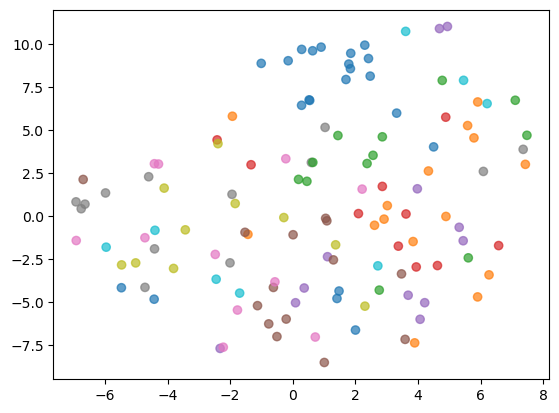

In [8]:
# Label Mapping: If labels aren’t consecutive integers, map them for better visualization
unique_labels = np.unique(val_labels)
label_map = {lbl: idx for idx, lbl in enumerate(unique_labels)}
val_labels_mapped = np.array([label_map[lbl] for lbl in val_labels])
scatter = plt.scatter(emb_val_tsne[:, 0], emb_val_tsne[:, 1], c=val_labels_mapped, cmap='tab10', alpha=0.7)

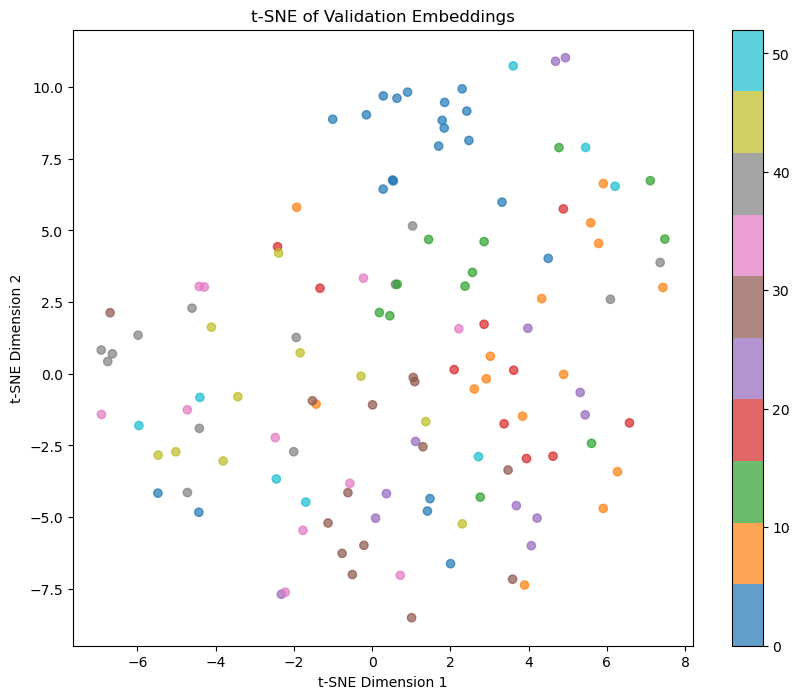

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
scatter = plt.scatter(emb_val_tsne[:, 0], emb_val_tsne[:, 1], c=val_labels, cmap='tab10', alpha=0.7)
plt.colorbar(scatter)
plt.title('t-SNE of Validation Embeddings')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()

3D T-SNE

/Users/amee/miniconda3/envs/pytorch_env/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/Users/amee/miniconda3/envs/pytorch_env/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


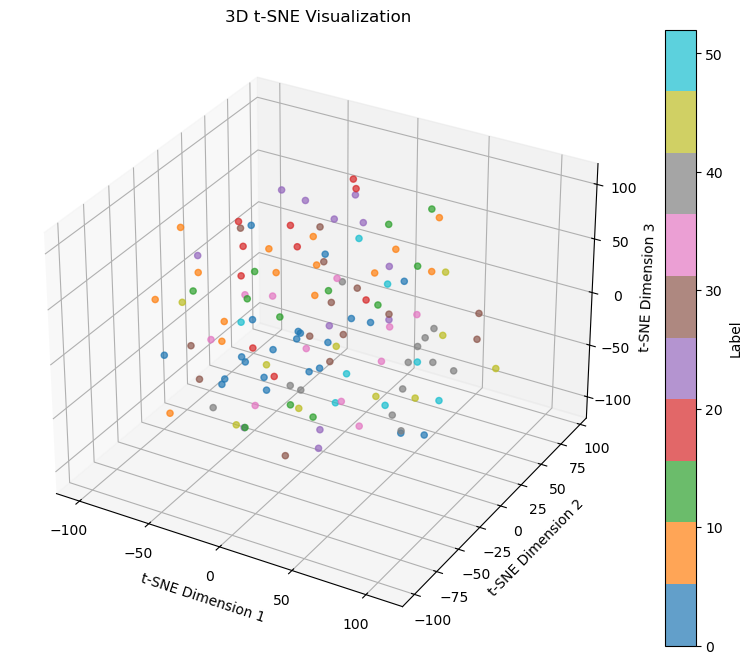

In [10]:
tsne3d = TSNE(n_components=3, # 3D visualization !!
    perplexity=10,           # smaller than usual, rule of thumb: ~ N/3
    n_iter=1000,            # more iterations help stabilize the low-sample regime
    init='random',          # or 'pca' if you want structured starting points
    learning_rate='auto',   # let sklearn choose an adaptive learning rate
    random_state=42
)
emb3d_val_tsne = tsne3d.fit_transform(val_embeddings)
emb3d_train_tsne = tsne3d.fit_transform(train_embeddings.numpy())

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(emb3d_val_tsne[:, 0], emb3d_val_tsne[:, 1], emb3d_val_tsne[:, 2], c=val_labels, cmap='tab10', alpha=0.7)

cbar = fig.colorbar(scatter)
cbar.set_label('Label')

ax.set_xlabel('t-SNE Dimension 1')
ax.set_ylabel('t-SNE Dimension 2')
ax.set_zlabel('t-SNE Dimension 3')
ax.set_title('3D t-SNE Visualization')

plt.show()

Print Thumbnails on T-SNE

In [11]:
# Get file paths in order to print thumbnails
from PIL import Image
from PIL.Image import Resampling 
import os

query_paths_flat = [item for sublist in query_paths for item in (sublist if isinstance(sublist, (list, tuple)) else [sublist])]
gallery_paths_flat = [item for sublist in gallery_paths for item in (sublist if isinstance(sublist, (list, tuple)) else [sublist])]
img_paths = query_paths_flat + gallery_paths_flat

# If you have file paths in 'image_paths'
images = [Image.open(os.path.join(config['dataset'],path)).convert('RGB') for path in img_paths]

# Resize to thumbnails
thumbnail_size = (32, 32)
thumbnails = [img.copy() for img in images]
for img in thumbnails:
    img.thumbnail(thumbnail_size, Resampling.LANCZOS)

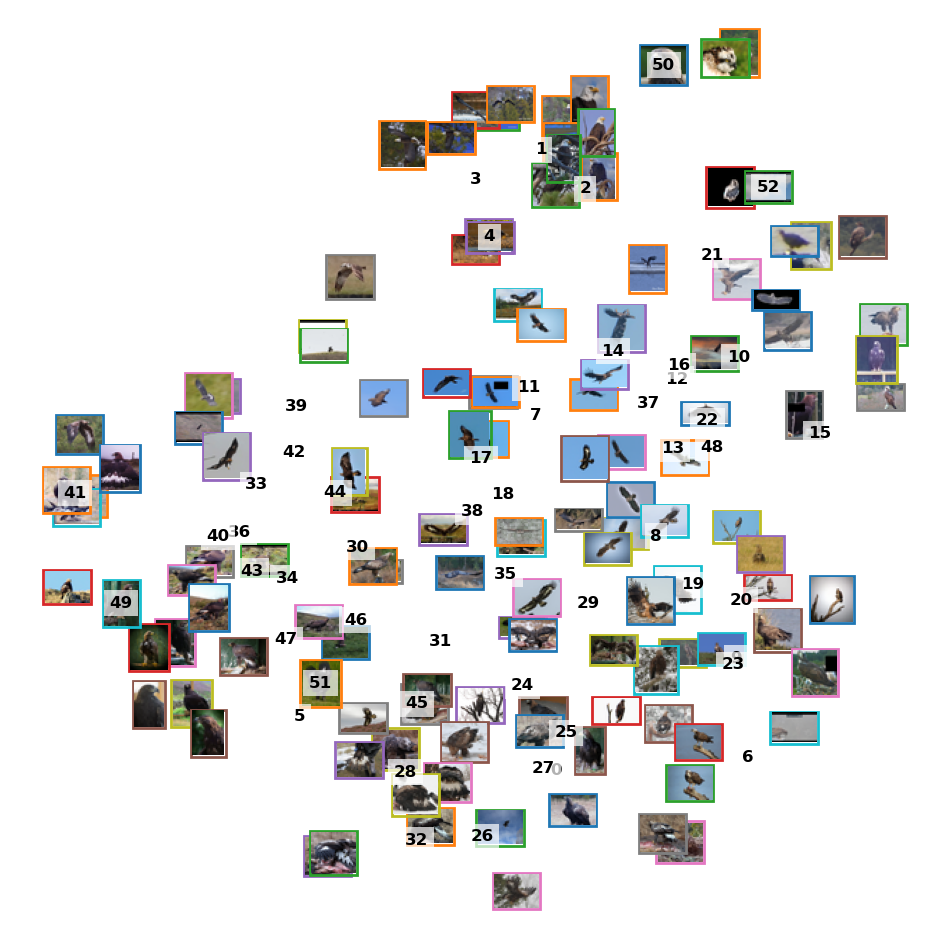

In [12]:
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib import cm
from collections import defaultdict

# Assuming 'val_labels' is a list of labels matching the embeddings
unique_labels = np.unique(val_labels)
label_to_color = {label: cm.tab10(i % 10) for i, label in enumerate(unique_labels)}

# Set up the plot
fig, ax = plt.subplots(figsize=(12, 12))
ax.scatter(emb_val_tsne[:, 0], emb_val_tsne[:, 1], alpha=0)  # Invisible points for scaling

# Add images with colored borders
for i, (x, y) in enumerate(emb_val_tsne):
    label = val_labels[i]
    color = label_to_color[label]
    imagebox = OffsetImage(thumbnails[i], zoom=1.0)
    ab = AnnotationBbox(imagebox, (x, y), frameon=True, boxcoords="data", pad=0.1,
                        box_alignment=(0.5, 0.5), bboxprops=dict(edgecolor=color, facecolor='none', linewidth=2))
    ax.add_artist(ab)

# Add text labels at cluster centroids
label_points = defaultdict(list)
for (x, y), label in zip(emb_val_tsne, val_labels):
    label_points[label].append((x, y))

for label, points in label_points.items():
    points = np.array(points)
    centroid = points.mean(axis=0)
    ax.text(centroid[0], centroid[1], str(label), fontsize=12, weight='bold', color='black',
            ha='center', va='center', bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

# Clean up the plot
ax.set_xlim(emb_val_tsne[:, 0].min() - 1, emb_val_tsne[:, 0].max() + 1)
ax.set_ylim(emb_val_tsne[:, 1].min() - 1, emb_val_tsne[:, 1].max() + 1)
ax.axis('off')
plt.show()

# PCA -> UMAP

PCA cleans up high‑D noise and speeds up both UMAP/t‑SNE.

In [13]:
from sklearn.decomposition import PCA

pca = PCA(n_components=50, random_state=42)
pca.fit(train_embeddings)  # fit only once

emb_train_pca = pca.transform(train_embeddings)
emb_val_pca = pca.transform(val_embeddings)
emb_query_pca = pca.transform(query_embeddings)
emb_gallery_pca = pca.transform(gallery_embeddings)

In [14]:
# UMAP on the PCA output
# UMAP (with small n_neighbors) excels at revealing tight clusters when you have very few samples per class

import umap # reserves local clusters tightly (critical when classes have <10 samples) while retaining some global layout

reducer = umap.UMAP(
    n_neighbors=5,
    min_dist=0.05,
    metric='cosine',
    init='spectral',
    random_state=42
)
reducer.fit(emb_train_pca)  # fit on training distribution

emb_train_2d = reducer.transform(emb_train_pca)
emb_query_2d = reducer.transform(emb_query_pca)
emb_gallery_2d = reducer.transform(emb_gallery_pca)

/Users/amee/miniconda3/envs/pytorch_env/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/amee/miniconda3/envs/pytorch_env/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/Users/amee/miniconda3/envs/pytorch_env/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/amee/miniconda3/envs/pytorch_env/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/amee/miniconda3/envs/pytorch_

In [15]:
# OR  t‑SNE on the PCA output -- Why t‑SNE?  “purely local” emphasis.
# t‑SNE remains an option if you prefer its sharper local separations, but you must tune perplexity and other hyperparameters carefully.
# tsne = TSNE(
#     n_components=2,
#     perplexity=5,
#     learning_rate=300,
#     init='pca',
#     early_exaggeration=8,
#     random_state=42,
#     n_jobs=8
# )
# emb_2d = tsne.fit_transform(emb_val_pca)

/var/folders/gx/lbyd01qj4yg41hbq5y7z8j380000gn/T/ipykernel_2171/3494060737.py:37: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


int labels:  [62, 14, 63, 62, 55, 37, 8, 42, 11, 36, 39, 36, 21, 17, 46, 37, 32, 64, 65, 43, 4, 62, 13, 55, 10, 12, 14, 45, 5, 52, 63, 22, 54, 5, 4, 51, 5, 17, 8, 51, 58, 4, 34, 62, 4, 24, 29, 56, 56, 59, 61, 11, 46, 3, 37, 57, 49, 13, 4, 30, 66, 49, 13, 11, 11, 10, 38, 62, 7, 11, 2, 55, 60, 35, 4, 7, 5, 39, 51, 46, 51, 13, 4, 4, 31, 51, 8, 38, 11, 37, 40, 68, 11, 11, 38, 53, 4, 30, 41, 55, 49, 23, 36, 30, 41, 28, 0, 15, 19, 67, 28, 4, 30, 44, 4, 11, 22, 4, 25, 4, 5, 4, 10, 11, 35, 49, 4, 4, 4, 44, 25, 22, 39, 12, 49, 1, 13, 38, 5, 17, 11, 8, 13, 5, 5, 18, 62, 5, 65, 8, 11, 7, 5, 5, 41, 11, 16, 49, 8, 30, 4, 4, 40, 35, 7, 4, 13, 51, 54, 12, 41, 40, 17, 4, 12, 51, 18, 8, 40, 37, 46, 16, 50, 62, 17, 37, 27, 24, 40, 4, 30, 24, 62, 46, 11, 39, 4, 4, 43, 54, 38, 12, 49, 51, 33, 62, 62, 61, 14, 26, 4, 0, 10, 51, 68, 5, 4, 5, 11, 13, 4, 51, 4, 5, 13, 25, 61, 55, 49, 48, 12, 48, 19, 4, 40, 51, 3, 67, 57, 30, 8, 4, 11, 4, 62, 41, 41, 14, 5, 30, 20, 46, 27, 5, 4, 4, 30, 4, 52, 11, 1, 38, 50, 34,

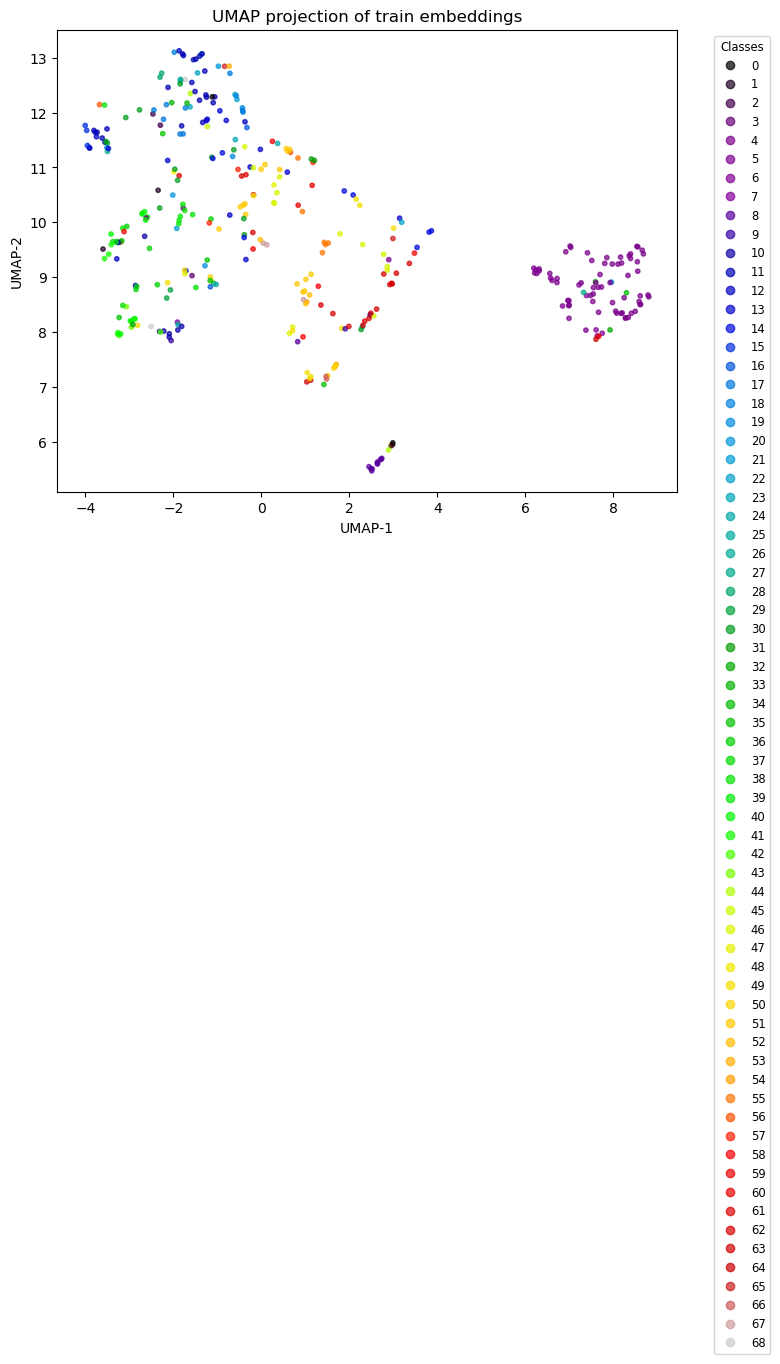

In [16]:
# Ensure train_labels are converted to Python integers
unique_labels = list(set(int(lab) for lab in train_labels))  # Convert tensors to integers
label_to_int = {lab: i for i, lab in enumerate(unique_labels)}
int_labels = [label_to_int[int(lab)] for lab in train_labels]  # Convert tensors to integers here as well
print('int labels: ', int_labels)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    emb_train_2d[:, 0],
    emb_train_2d[:, 1],
    c=int_labels,          # color by integer label
    cmap='nipy_spectral',          # up to 20 distinct colors; switch if you have more classes
    alpha=0.7,
    s=10                   # marker size
)
plt.title("UMAP projection of train embeddings")
plt.xlabel("UMAP‑1")
plt.ylabel("UMAP‑2")

# Create a legend
n_classes = len(unique_labels)
# Get one handle per class
handles, _ = scatter.legend_elements(
    prop="colors",
    num=n_classes  # ensure one handle per class
)
plt.legend(
    handles,
    unique_labels,
    title="Classes",
    bbox_to_anchor=(1.05, 1),
    loc="upper left",
    fontsize="small",
    title_fontsize="small",
)

plt.tight_layout()
plt.show()

# Retrieval

NEW IDEA: 

1. Plot full training set in a neutral style (e.g. small, light‐gray points) to see the overall manifold.

2. Select a handful of query samples ~ 10
3. For each query:
    - Plot its embedding as a larger colored marker (or its thumbnail).
    - Plot its top‑k gallery matches (e.g. k=3) around it, using the same color but a different marker shape (or a thumbnail).


Results in:
- The global shape (all train points).
- The local retrieval neighborhoods for  example queries.
- Color encodes the identity (class) to see whether the gallery matches actually cluster with the query’s class.

In [18]:
from wildlife_tools.similarity import CosineSimilarity


similarity_function = CosineSimilarity()
distmat_query_gallery = 1-similarity_function(query_embeddings, gallery_embeddings)['cosine']

/Users/amee/miniconda3/envs/pytorch_env/lib/python3.12/site-packages/wildlife_tools/similarity/cosine.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a, b = torch.tensor(a), torch.tensor(b)


Just show query and gallery embeddings should be nearby

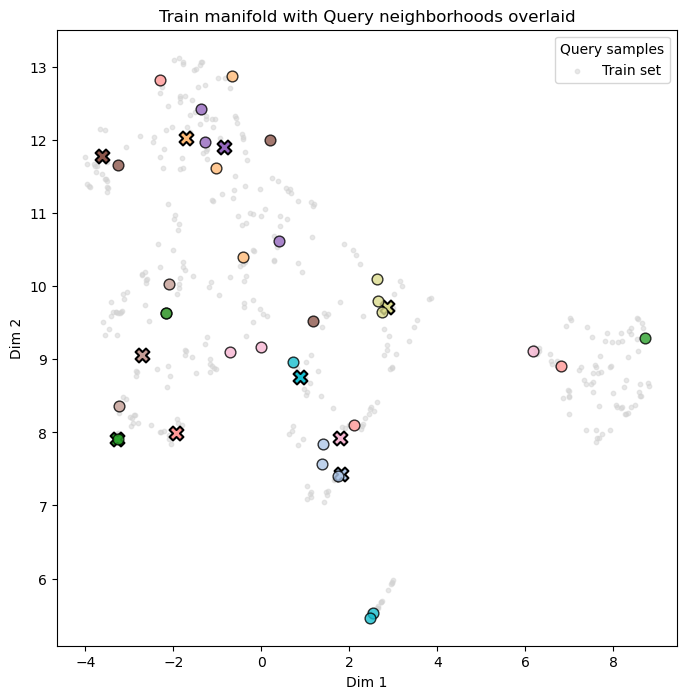

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# emb_train_2d: (N_train, 2)
# train_labels: length-N_train list of class IDs (or strings)
# emb_query_2d: (N_query, 2)
# query_labels: length-N_query list
# emb_gallery_2d: (N_gallery, 2)
# gallery_labels: length-N_gallery list


# # Ensure all labels are plain ints
# unique_labels = list(set(int(lab) for lab in val_labels))
# label_to_int = {lab: i for i, lab in enumerate(unique_labels)}
# int_labels = [label_to_int[int(lab)] for lab in val_labels]


# 1) Plot all train in light gray
plt.figure(figsize=(8,8))
plt.scatter(
    emb_train_2d[:,0], emb_train_2d[:,1],
    c='lightgray', s=10, alpha=0.5, label='Train set'
)

# 2) Choose some query indices to visualize
num_visual = 10
query_idxs = np.random.choice(len(emb_query_2d), size=num_visual, replace=False)

# 3) For each chosen query
for qi in query_idxs:
    q_point = emb_query_2d[qi]
    q_label = query_labels[qi]
    
    # Color for this class
    q_label_int = label_to_int[int(q_label)]  # convert tensor to int
    color = plt.cm.tab20(q_label_int % 20)

    
    # a) Plot the query itself
    plt.scatter(
        q_point[0], q_point[1],
        c=[color], s=100, marker='X',
        edgecolor='k', linewidth=1.5,
        label=f"Query {q_label}" if qi==query_idxs[0] else None
    )
    
    # b) Find top-k gallery matches for this query
    # (Assuming you have precomputed distmat_query_gallery)
    dists = distmat_query_gallery[qi]  # shape (N_gallery,)
    topk = np.argsort(dists)[:3]
    
    # Plot those gallery points
    for gj in topk:
        g_point = emb_gallery_2d[gj]
        plt.scatter(
            g_point[0], g_point[1],
            c=[color], s=60, marker='o',
            edgecolor='k', linewidth=1,
            alpha=0.8,
            label=None
        )

# 4) Final touches
plt.title("Train manifold with Query neighborhoods overlaid")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
# Create a legend only for the query markers
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[:1], labels[:1], title="Query samples", loc='best')
plt.show()


With thumbnails

Length of query_paths_flat: 49
First few query_paths_flat: ['goleag/Bernheim_athena/wnp-aigle-eagle-1-640x427.jpg', 'baleag/BigBear_jackie/aug-13-2023.jpg', 'baleag/BigBear_shadow/oct23_2022.jpg', 'baleag/Dayton_orv/nov-2023-daytons-bald-eagle-update-willa-orv-still-thriving-after-7-v0-7oyolmrm0i2c1.png', 'baleag/Dayton_willa/Sep-2023-the-carillon-park-dayton-bald-eagles-have-been-enjoying-v0-6jmgqni81bpb1.png']
Length of gallery_paths_flat: 78
First few gallery_paths_flat: ['goleag/Bernheim_athena/both_athena_newpartner.jpg', 'baleag/BigBear_jackie/jan_11_2023.jpg', 'baleag/BigBear_jackie/june28-2022.png', 'baleag/BigBear_jackie/feb_8_2023.jpg', 'baleag/BigBear_jackie/jan_2_2019.jpg']
Length of img_paths: 127
First few img_paths: ['goleag/Bernheim_athena/wnp-aigle-eagle-1-640x427.jpg', 'baleag/BigBear_jackie/aug-13-2023.jpg', 'baleag/BigBear_shadow/oct23_2022.jpg', 'baleag/Dayton_orv/nov-2023-daytons-bald-eagle-update-willa-orv-still-thriving-after-7-v0-7oyolmrm0i2c1.png', 'baleag/Day

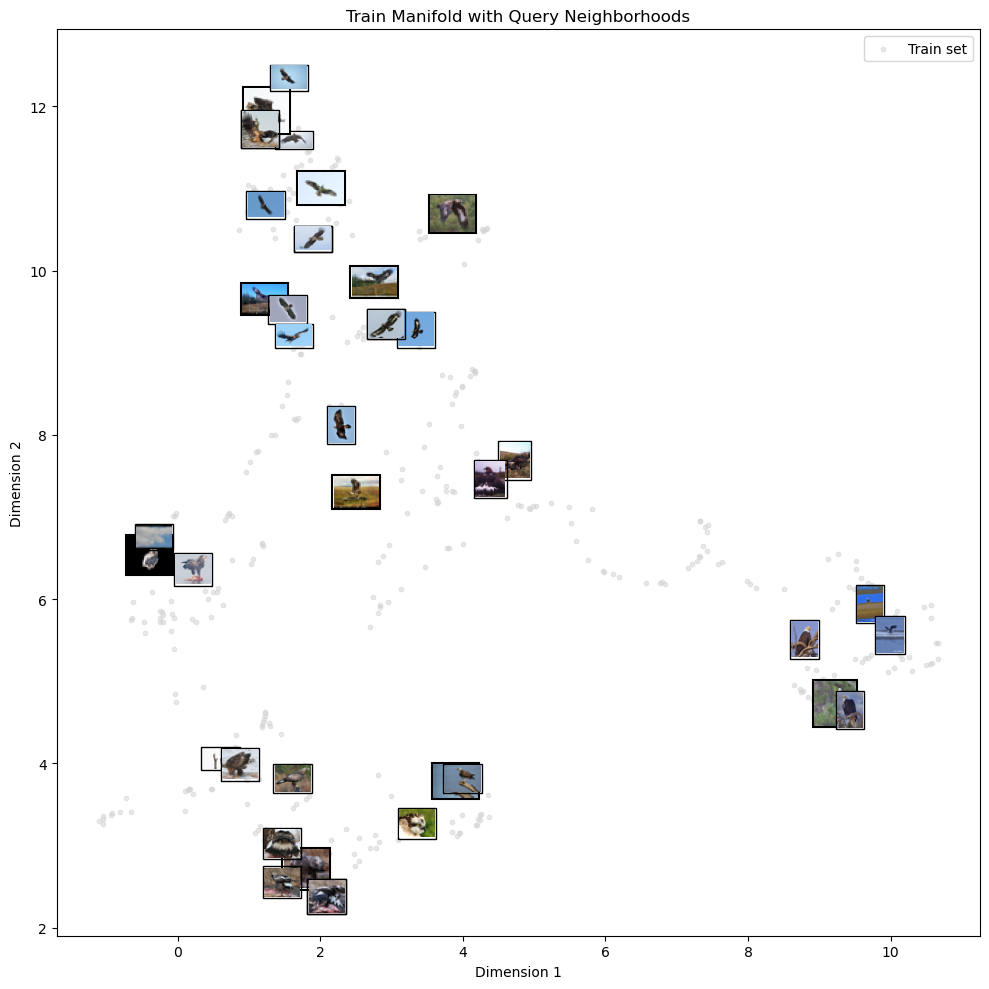

In [42]:
import matplotlib.pyplot as plt
import numpy as np
from wildlife_tools.similarity import CosineSimilarity
from PIL import Image, UnidentifiedImageError
from PIL.Image import Resampling
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import torch
import os

# Convert tensor labels to clean format
train_labels_np = train_labels.cpu().numpy() if torch.is_tensor(train_labels) else np.array(train_labels)
query_labels_np = query_labels.cpu().numpy() if torch.is_tensor(query_labels) else np.array(query_labels)
gallery_labels_np = gallery_labels.cpu().numpy() if torch.is_tensor(gallery_labels) else np.array(gallery_labels)

train_labels_clean = [int(lab) for lab in train_labels_np]
query_labels_clean = [int(lab) for lab in query_labels_np]
gallery_labels_clean = [int(lab) for lab in gallery_labels_np]

# Create label mapping
all_labels = np.concatenate([train_labels_clean, query_labels_clean, gallery_labels_clean])
unique_labels = np.unique(all_labels)
label_to_int = {lab: i for i, lab in enumerate(unique_labels)}

train_labels_int = [label_to_int[lab] for lab in train_labels_clean]
query_labels_int = [label_to_int[lab] for lab in query_labels_clean]
gallery_labels_int = [label_to_int[lab] for lab in gallery_labels_clean]

# 1) Plot all training points
plt.figure(figsize=(10, 10))
plt.scatter(
    emb_train_2d[:, 0], emb_train_2d[:, 1],
    c='lightgray', s=10, alpha=0.5, label='Train set'
)

# 2) Choose query indices
num_visual = 10
query_idxs = np.random.choice(len(emb_query_2d), size=num_visual, replace=False)

# 3) Flatten paths and load thumbnails (using your approach)
use_thumbnails = True
if use_thumbnails:
    # Flatten query_paths and gallery_paths
    query_paths_flat = [item for sublist in query_paths for item in (sublist if isinstance(sublist, (list, tuple)) else [sublist])]
    gallery_paths_flat = [item for sublist in gallery_paths for item in (sublist if isinstance(sublist, (list, tuple)) else [sublist])]
    img_paths = query_paths_flat + gallery_paths_flat

    # Debug paths to confirm flattening
    print("Length of query_paths_flat:", len(query_paths_flat))
    print("First few query_paths_flat:", query_paths_flat[:5])
    print("Length of gallery_paths_flat:", len(gallery_paths_flat))
    print("First few gallery_paths_flat:", gallery_paths_flat[:5])
    print("Length of img_paths:", len(img_paths))
    print("First few img_paths:", img_paths[:5])

    # Load images with dataset path prefix
    thumbnails = []
    for path in img_paths:
        try:
            full_path = os.path.join(config['dataset'], path)
            img = Image.open(full_path).convert('RGB')
            img.thumbnail((32, 32), Resampling.LANCZOS)
            thumbnails.append(img)
        except (FileNotFoundError, UnidentifiedImageError, TypeError) as e:
            print(f"Error loading image at {path}: {e}")
            thumbnails.append(Image.new('RGB', (32, 32), (128, 128, 128)))  # Placeholder

    print("Number of thumbnails created:", len(thumbnails))

# 4) Plot queries and gallery matches
for qi in query_idxs:
    q_point = emb_query_2d[qi]
    q_label = query_labels_clean[qi]
    q_label_int = label_to_int[q_label]
    color = plt.cm.tab20(q_label_int % 20)

    if use_thumbnails:
        imagebox = OffsetImage(thumbnails[qi], zoom=1.0)
        ab = AnnotationBbox(imagebox, (q_point[0], q_point[1]), frameon=True,
                            boxcoords="data", pad=0.1,
                            box_alignment=(0.5, 0.5),
                            bboxprops=dict(edgecolor='black', facecolor='none', linewidth=1.5))
        plt.gca().add_artist(ab)
    else:
        plt.scatter(
            q_point[0], q_point[1],
            c=[color], s=100, marker='X',
            edgecolor='k', linewidth=1.5,
            label=f"Query (class {q_label})" if qi == query_idxs[0] else None
        )

    dists = distmat_query_gallery[qi]
    topk = np.argsort(dists)[:3]  # Highest similarities

    for gj in topk:
        g_point = emb_gallery_2d[gj]
        g_label = gallery_labels_clean[gj]
        g_label_int = label_to_int[g_label]
        if use_thumbnails:
            gallery_idx = gj + len(query_paths_flat)
            imagebox = OffsetImage(thumbnails[gallery_idx], zoom=0.8)
            ab = AnnotationBbox(imagebox, (g_point[0], g_point[1]), frameon=True,
                                boxcoords="data", pad=0.1,
                                box_alignment=(0.5, 0.5),
                                bboxprops=dict(edgecolor='black', facecolor='none', linewidth=1))
            plt.gca().add_artist(ab)
        else:
            plt.scatter(
                g_point[0], g_point[1],
                c=[color], s=60, marker='o',
                edgecolor='k', linewidth=1,
                alpha=0.8,
                label=None
            )

plt.title("Train Manifold with Query Neighborhoods")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.legend(loc='best')
plt.tight_layout()
plt.show()

Showing correct or false predictions

Length of query_identities_flat: 49
First few query_identities_flat: ['Bernheim_athena', 'BigBear_jackie', 'BigBear_shadow', 'Dayton_orv', 'Dayton_willa']
Length of gallery_identities_flat: 78
First few gallery_identities_flat: ['Bernheim_athena', 'BigBear_jackie', 'BigBear_jackie', 'BigBear_jackie', 'BigBear_jackie']
49
78
Length of predictions: 49
First few predictions: ['BigBear_shadow', 'SouthScotland_emily121', 'Orrhult_248H', 'SouthScotland_haworth164', 'SouthScotland_emily121']
First few true query_identities: ['Bernheim_athena', 'BigBear_jackie', 'BigBear_shadow', 'Dayton_orv', 'Dayton_willa']


/Users/amee/Documents/code/master-thesis/EagleID/notebooks/../utils/triplet_loss_utils.py:138: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  results = pd.DataFrame(results).T.fillna(method="ffill").T
/var/folders/gx/lbyd01qj4yg41hbq5y7z8j380000gn/T/ipykernel_70464/855579512.py:71: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("Set2", 9)


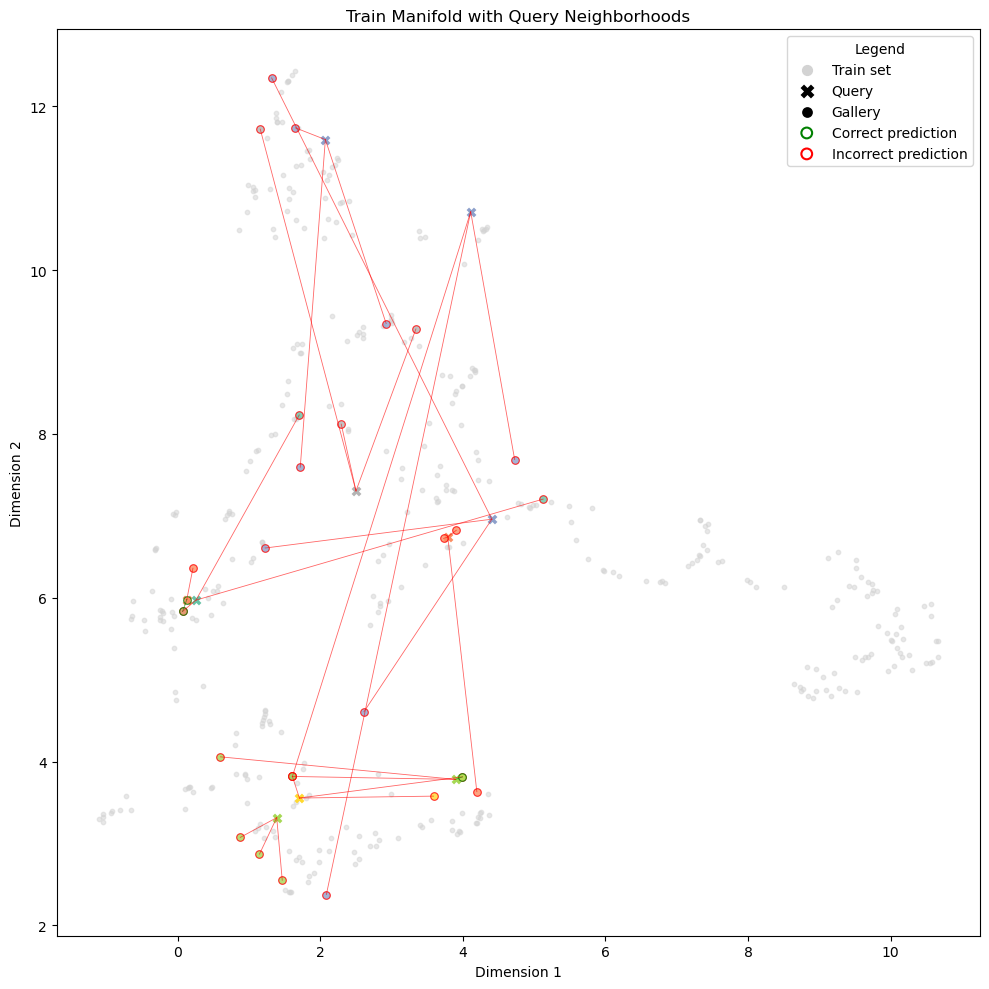

In [43]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from collections import defaultdict
import pandas as pd
from wildlife_tools.similarity import CosineSimilarity
from utils.triplet_loss_utils import KnnClassifier

# Convert tensor labels
train_labels_np = train_labels.cpu().numpy() if torch.is_tensor(train_labels) else np.array(train_labels)
query_labels_np = query_labels.cpu().numpy() if torch.is_tensor(query_labels) else np.array(query_labels)
gallery_labels_np = gallery_labels.cpu().numpy() if torch.is_tensor(gallery_labels) else np.array(gallery_labels)

train_labels_clean = [int(lab) for lab in train_labels_np]
query_labels_clean = [int(lab) for lab in query_labels_np]
gallery_labels_clean = [int(lab) for lab in gallery_labels_np]

# Flatten identities (since they may be nested from batch concatenation)
def flatten_list(nested_list):
    flat_list = []
    for item in nested_list:
        if isinstance(item, (list, tuple)):
            flat_list.extend(flatten_list(item))
        elif isinstance(item, str):
            flat_list.append(item)
        else:
            print(f"Warning: Non-string identity found: {item} (type: {type(item)})")
            flat_list.append(str(item))
    return flat_list

query_identities_flat = flatten_list(query_identities)
gallery_identities_flat = flatten_list(gallery_identities)

# Debug identities
print("Length of query_identities_flat:", len(query_identities_flat))
print("First few query_identities_flat:", query_identities_flat[:5])
print("Length of gallery_identities_flat:", len(gallery_identities_flat))
print("First few gallery_identities_flat:", gallery_identities_flat[:5])

# Create label mapping for colors
all_labels = np.concatenate([train_labels_clean, query_labels_clean, gallery_labels_clean])
unique_labels = np.unique(all_labels)
label_to_int = {lab: i for i, lab in enumerate(unique_labels)}

train_labels_int = [label_to_int[lab] for lab in train_labels_clean]
query_labels_int = [label_to_int[lab] for lab in query_labels_clean]
gallery_labels_int = [label_to_int[lab] for lab in gallery_labels_clean]

# Use KnnClassifier to predict query identities
classifier = KnnClassifier(k=1, database_labels=np.array(gallery_identities_flat))
predictions = classifier(distmat_query_gallery)

# Ensure predictions are a list or array
predictions = predictions.tolist() if isinstance(predictions, np.ndarray) else list(predictions)

# Verify predictions align with query_identities
print("Length of predictions:", len(predictions))
print("First few predictions:", predictions[:5])
print("First few true query_identities:", query_identities_flat[:5])

# Plotting
plt.figure(figsize=(10, 10))
plt.scatter(
    emb_train_2d[:, 0], emb_train_2d[:, 1],
    c='lightgray', s=10, alpha=0.5, label='Train set'
)

num_visual = 10
query_idxs = np.random.choice(len(emb_query_2d), size=num_visual, replace=False)

cmap = plt.cm.get_cmap("Set2", 9) 

for qi in query_idxs:
    q_point = emb_query_2d[qi]
    q_label = query_labels_clean[qi]
    q_label_int = label_to_int[q_label]
    color = cmap(q_label_int % cmap.N)

    # Plot query
    plt.scatter(
        q_point[0], q_point[1],
        c=[color], s=50, marker='X',
        linewidth=0  # No outline
    )

    dists = distmat_query_gallery[qi]
    topk = np.argsort(dists)[:3]

    for gj in topk:
        g_point = emb_gallery_2d[gj]
        g_label = gallery_labels_clean[gj]
        g_label_int = label_to_int[g_label]
        true_identity = query_identities_flat[qi]
        is_correct = true_identity == gallery_identities_flat[gj]
        edge_color = 'green' if is_correct else 'red'

        # Draw connection line
        plt.plot(
            [q_point[0], g_point[0]],
            [q_point[1], g_point[1]],
            color=edge_color,
            linestyle='-', linewidth=0.6, alpha=0.6
        )

        plt.scatter(
            g_point[0], g_point[1],
            c=[color], s=30, marker='o',
            edgecolor=edge_color, linewidth=0.8,
            alpha=0.8
        )

# Create custom legend
handles = [
    plt.scatter([], [], c='lightgray', s=50, marker='o', label='Train set'),
    plt.scatter([], [], c='black', s=100, marker='X', linewidth=0, label='Query'),
    plt.scatter([], [], c='black', s=60, marker='o', linewidth=0, label='Gallery'),
    plt.scatter([], [], c='none', s=60, marker='o', edgecolor='green', linewidth=1.5, label='Correct prediction'),
    plt.scatter([], [], c='none', s=60, marker='o', edgecolor='red', linewidth=1.5, label='Incorrect prediction')
]
labels = ['Train set', 'Query', 'Gallery', 'Correct prediction', 'Incorrect prediction']

plt.title("Train Manifold with Query Neighborhoods")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.legend(handles, labels, loc='best', title="Legend")
plt.tight_layout()

Showing ground truths for each query

Length of query_identities_flat: 49
First few query_identities_flat: ['Bernheim_athena', 'BigBear_jackie', 'BigBear_shadow']
Length of gallery_identities_flat: 78
First few gallery_identities_flat: ['Bernheim_athena', 'BigBear_jackie', 'BigBear_jackie']
49
78
Length of predictions: 49
First few predictions: ['BigBear_shadow', 'SouthScotland_emily121', 'Orrhult_248H']
First few true query_identities: ['Bernheim_athena', 'BigBear_jackie', 'BigBear_shadow']


/Users/amee/Documents/code/master-thesis/EagleID/notebooks/../utils/triplet_loss_utils.py:138: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  results = pd.DataFrame(results).T.fillna(method="ffill").T
/var/folders/gx/lbyd01qj4yg41hbq5y7z8j380000gn/T/ipykernel_70464/4292106563.py:71: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("Set2", 9)


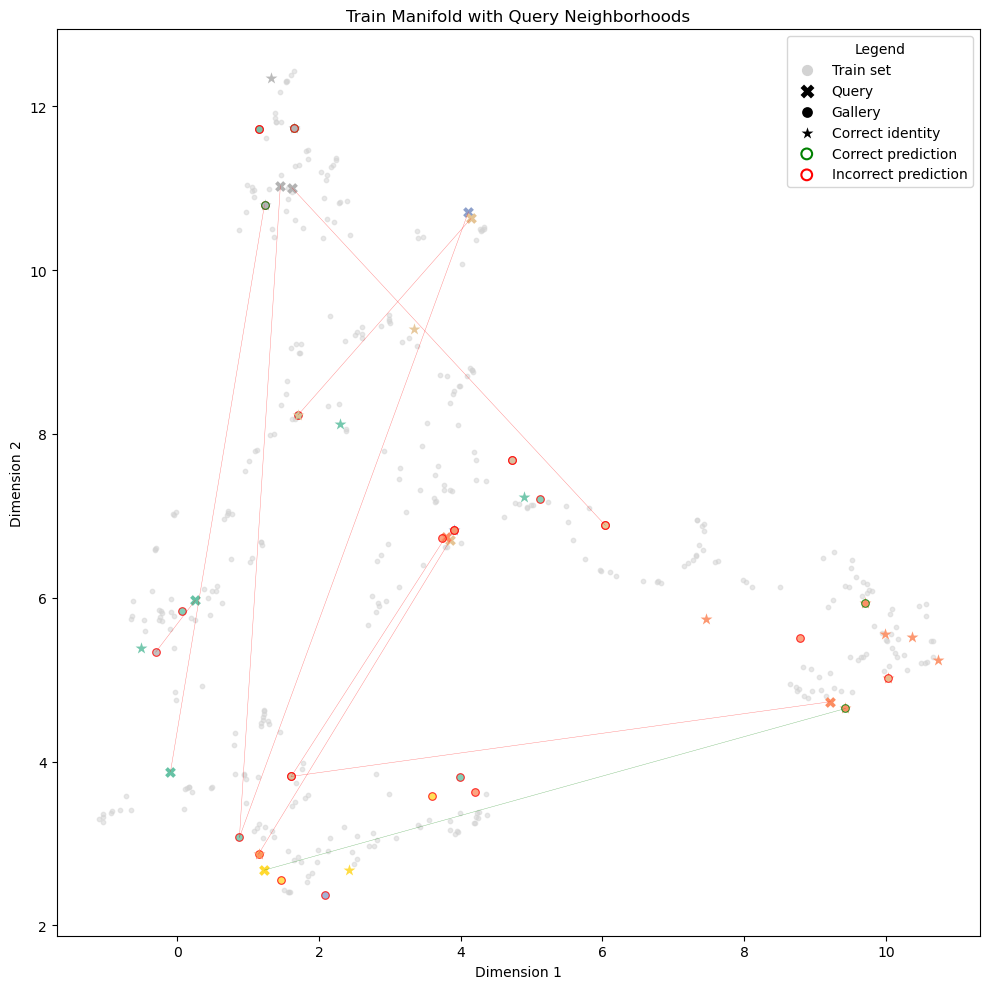

In [44]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from collections import defaultdict
import pandas as pd
from wildlife_tools.similarity import CosineSimilarity
from utils.triplet_loss_utils import KnnClassifier

# Convert tensor labels
train_labels_np = train_labels.cpu().numpy() if torch.is_tensor(train_labels) else np.array(train_labels)
query_labels_np = query_labels.cpu().numpy() if torch.is_tensor(query_labels) else np.array(query_labels)
gallery_labels_np = gallery_labels.cpu().numpy() if torch.is_tensor(gallery_labels) else np.array(gallery_labels)

train_labels_clean = [int(lab) for lab in train_labels_np]
query_labels_clean = [int(lab) for lab in query_labels_np]
gallery_labels_clean = [int(lab) for lab in gallery_labels_np]

# Flatten identities
def flatten_list(nested_list):
    flat_list = []
    for item in nested_list:
        if isinstance(item, (list, tuple)):
            flat_list.extend(flatten_list(item))
        elif isinstance(item, str):
            flat_list.append(item)
        else:
            print(f"Warning: Non-string identity found: {item} (type: {type(item)})")
            flat_list.append(str(item))
    return flat_list

query_identities_flat = flatten_list(query_identities)
gallery_identities_flat = flatten_list(gallery_identities)

# Debug identities
print("Length of query_identities_flat:", len(query_identities_flat))
print("First few query_identities_flat:", query_identities_flat[:3])
print("Length of gallery_identities_flat:", len(gallery_identities_flat))
print("First few gallery_identities_flat:", gallery_identities_flat[:3])

# Create label mapping for colors
all_labels = np.concatenate([train_labels_clean, query_labels_clean, gallery_labels_clean])
unique_labels = np.unique(all_labels)
label_to_int = {lab: i for i, lab in enumerate(unique_labels)}

train_labels_int = [label_to_int[lab] for lab in train_labels_clean]
query_labels_int = [label_to_int[lab] for lab in query_labels_clean]
gallery_labels_int = [label_to_int[lab] for lab in gallery_labels_clean]

# Use KnnClassifier to predict query identities
classifier = KnnClassifier(k=1, database_labels=np.array(gallery_identities_flat))
predictions = classifier(distmat_query_gallery)
predictions = predictions.tolist() if isinstance(predictions, np.ndarray) else list(predictions)

# Verify predictions
print("Length of predictions:", len(predictions))
print("First few predictions:", predictions[:3])
print("First few true query_identities:", query_identities_flat[:3])

# Plotting
plt.figure(figsize=(10, 10))

# Plot training points
plt.scatter(
    emb_train_2d[:, 0], emb_train_2d[:, 1],
    c='lightgray', s=10, alpha=0.5
)

num_visual = 10
query_idxs = np.random.choice(len(emb_query_2d), size=num_visual, replace=False)

cmap = plt.cm.get_cmap("Set2", 9) 

for qi in query_idxs:
    q_point = emb_query_2d[qi]
    q_label = query_labels_clean[qi]
    q_label_int = label_to_int[q_label]
    color = cmap(q_label_int % cmap.N)

    # Draw connection line
    plt.plot(
        [q_point[0], g_point[0]],
        [q_point[1], g_point[1]],
        color=edge_color,
        linestyle='-', linewidth=0.3, alpha=0.5
    )

    # Plot query
    plt.scatter(
        q_point[0], q_point[1],
        c=[color], s=60, marker='X',
        linewidth=0  # No outline
    )

    # Plot correct identity matches (gallery points with same identity)
    true_identity = query_identities_flat[qi]
    correct_indices = [gj for gj in range(len(gallery_identities_flat)) if gallery_identities_flat[gj] == true_identity]
    
    for gj in correct_indices:
        g_point = emb_gallery_2d[gj]
        plt.scatter(
            g_point[0], g_point[1],
            c=[color], s=80, marker='*',  # Star marker for correct identity
            linewidth=0,  # No outline
            alpha=0.9
        )

    # Plot top-3 gallery matches
    dists = distmat_query_gallery[qi]
    topk = np.argsort(dists)[:3]

    for gj in topk:
        g_point = emb_gallery_2d[gj]
        g_label = gallery_labels_clean[gj]
        g_label_int = label_to_int[g_label]
        true_identity = query_identities_flat[qi]
        is_correct = true_identity == gallery_identities_flat[gj]
        edge_color = 'green' if is_correct else 'red'

        plt.scatter(
            g_point[0], g_point[1],
            c=[color], s=30, marker='o',
            edgecolor=edge_color, linewidth=0.8,
            alpha=0.8
        )

# Create custom legend
handles = [
    plt.scatter([], [], c='lightgray', s=50, marker='o', label='Train set'),
    plt.scatter([], [], c='black', s=100, marker='X', linewidth=0, label='Query'),
    plt.scatter([], [], c='black', s=60, marker='o', linewidth=0, label='Gallery'),
    plt.scatter([], [], c='black', s=80, marker='*', linewidth=0, label='Correct identity'),
    plt.scatter([], [], c='none', s=60, marker='o', edgecolor='green', linewidth=1.5, label='Correct prediction'),
    plt.scatter([], [], c='none', s=60, marker='o', edgecolor='red', linewidth=1.5, label='Incorrect prediction')
]
labels = ['Train set', 'Query', 'Gallery', 'Correct identity', 'Correct prediction', 'Incorrect prediction']

plt.title("Train Manifold with Query Neighborhoods")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.legend(handles, labels, loc='best', title="Legend")
plt.tight_layout()
plt.show()

## Print random train images

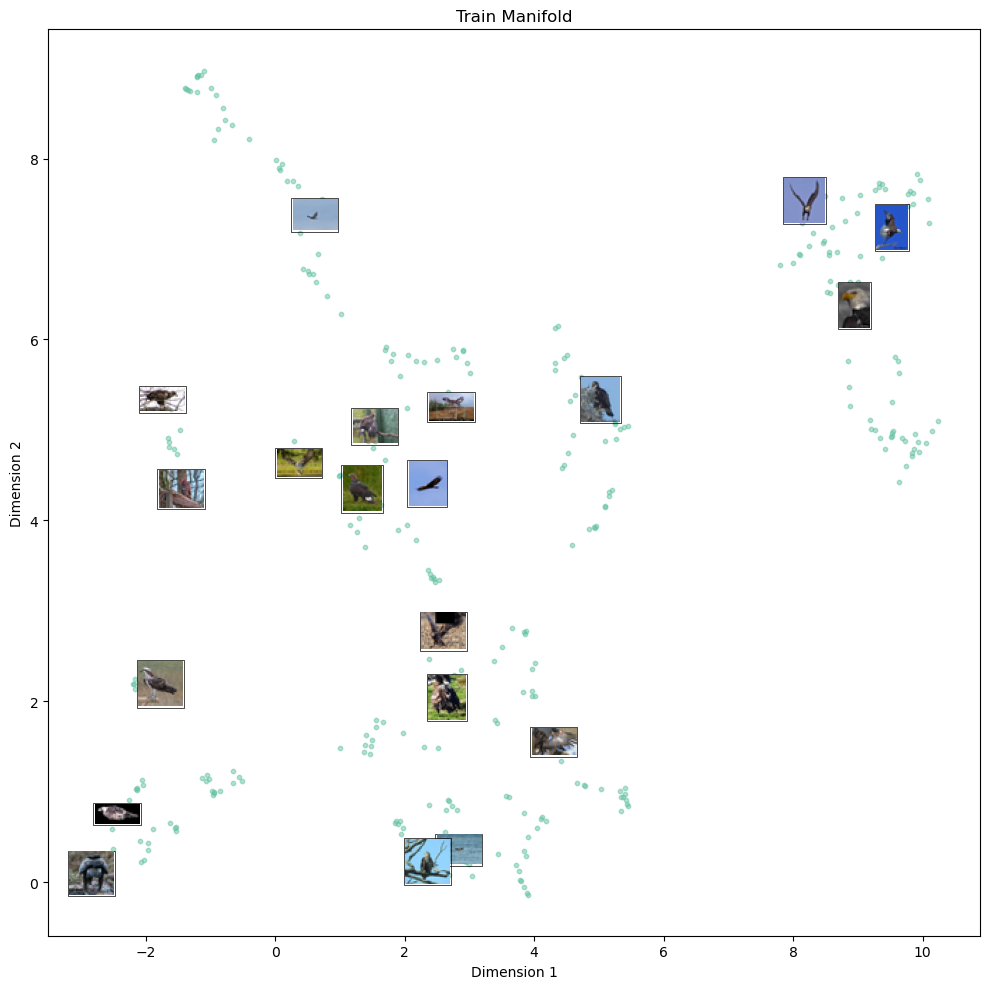

In [21]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from collections import defaultdict
import pandas as pd
from wildlife_tools.similarity import CosineSimilarity
from utils.triplet_loss_utils import KnnClassifier
from PIL import Image, UnidentifiedImageError
from PIL.Image import Resampling
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import os

# Convert tensor labels
train_labels_np = train_labels.cpu().numpy() if torch.is_tensor(train_labels) else np.array(train_labels)
train_labels_clean = [int(lab) for lab in train_labels_np]

# Flatten identities and paths
def flatten_list(nested_list):
    flat_list = []
    for item in nested_list:
        if isinstance(item, (list, tuple)):
            flat_list.extend(flatten_list(item))
        elif isinstance(item, str):
            flat_list.append(item)
        else:
            print(f"Warning: Non-string item found: {item} (type: {type(item)})")
            flat_list.append(str(item))
    return flat_list

train_identities_flat = flatten_list(train_identities)
train_paths_flat = flatten_list(train_paths)

# Create label mapping for colors
unique_labels = np.unique(train_labels_clean)
label_to_int = {lab: i for i, lab in enumerate(unique_labels)}
train_labels_int = [label_to_int[lab] for lab in train_labels_clean]

# Plotting
plt.figure(figsize=(10, 10))


# Plot training points
plt.scatter(
    emb_train_2d[:, 0], emb_train_2d[:, 1],
    c=[color], s=10, alpha=0.5
)

num_visual = 20
train_idxs = np.random.choice(len(emb_train_2d), size=num_visual, replace=False)

# Load thumbnails for training points only
thumbnails = {}
for ti in train_idxs:
    path = train_paths_flat[ti]
    try:
        full_path = os.path.join(config['dataset'], path)
        img = Image.open(full_path).convert('RGB')
        img.thumbnail((32, 32), Resampling.LANCZOS)
        thumbnails[ti] = img
    except (FileNotFoundError, UnidentifiedImageError, TypeError) as e:
        print(f"Error loading image at {path}: {e}")
        thumbnails[ti] = Image.new('RGB', (32, 32), (128, 128, 128))

for ti in train_idxs:
    t_point = emb_train_2d[ti]
    t_label = train_labels_clean[ti]
    t_label_int = label_to_int[t_label]
    color = plt.cm.tab20(t_label_int % 20)

    # Plot training point as thumbnail
    if ti in thumbnails:
        imagebox = OffsetImage(thumbnails[ti], zoom=1.0)
        ab = AnnotationBbox(imagebox, (t_point[0], t_point[1]), frameon=True,
                            boxcoords="data", pad=0.1,
                            box_alignment=(0.5, 0.5),
                            bboxprops=dict(edgecolor='black', facecolor='none', linewidth=0.5))
        plt.gca().add_artist(ab)
    else:
        plt.scatter(
            t_point[0], t_point[1],
            c=[color], s=100, marker='X',
            linewidth=0
        )


plt.title("Train Manifold")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.tight_layout()
plt.show()